In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshulm257/rice-disease-dataset")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/rice-disease-dataset...
Path to dataset files: /kaggle/input/rice-disease-dataset


In [ ]:
# BASIC EDA AND STRATIFIED SPLIT

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

# --- CONFIGURATION ---
dataset_path = Path('/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG') 

# --- 1. CREATE DATAFRAME ---
filepaths = []
labels = []

classes = sorted(os.listdir(dataset_path))
print(f"Found classes: {classes}")

for class_name in classes:
    class_dir = dataset_path / class_name
    if class_dir.is_dir():
        for img_file in os.listdir(class_dir):
            filepaths.append(str(class_dir / img_file))
            labels.append(class_name)

df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

print(f"\nTotal images found: {len(df)}")

# --- 2. STRATIFIED SPLIT (80% Train, 10% Val, 10% Test) ---
# First split: 80% Train, 20% Temp
train_df, temp_df = train_test_split(
    df, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42, 
    stratify=df['label']
)

# Second split: Split the 20% Temp into 10% Val and 10% Test
val_df, test_df = train_test_split(
    temp_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=42, 
    stratify=temp_df['label']
)

print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")
print(f"Test set size: {len(test_df)} images")

# --- 3. VERIFY BALANCE ---
print("\n--- Class Distribution (Percentage) ---")
print("Train:\n", train_df['label'].value_counts(normalize=True).mul(100).round(2))
print("\nValidation:\n", val_df['label'].value_counts(normalize=True).mul(100).round(2))

Found classes: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Sheath Blight']

Total images found: 3829
Training set size: 3063 images
Validation set size: 383 images
Test set size: 383 images

--- Class Distribution (Percentage) ---
Train:
 label
Healthy Rice Leaf        17.04
Brown Spot               16.88
Bacterial Leaf Blight    16.62
Leaf Blast               16.55
Sheath Blight            16.52
Leaf scald               16.39
Name: proportion, dtype: float64

Validation:
 label
Healthy Rice Leaf        17.23
Brown Spot               16.97
Sheath Blight            16.45
Leaf Blast               16.45
Leaf scald               16.45
Bacterial Leaf Blight    16.45
Name: proportion, dtype: float64


Class Mapping: {0: 'Bacterial Leaf Blight', 1: 'Brown Spot', 2: 'Healthy Rice Leaf', 3: 'Leaf Blast', 4: 'Leaf scald', 5: 'Sheath Blight'}
DataLoaders created successfully.

Visualizing Training Batch (with Augmentations):


/tmp/ipykernel_55/637541757.py:40: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=20, max_width=20, fill_value=0, p=0.5),


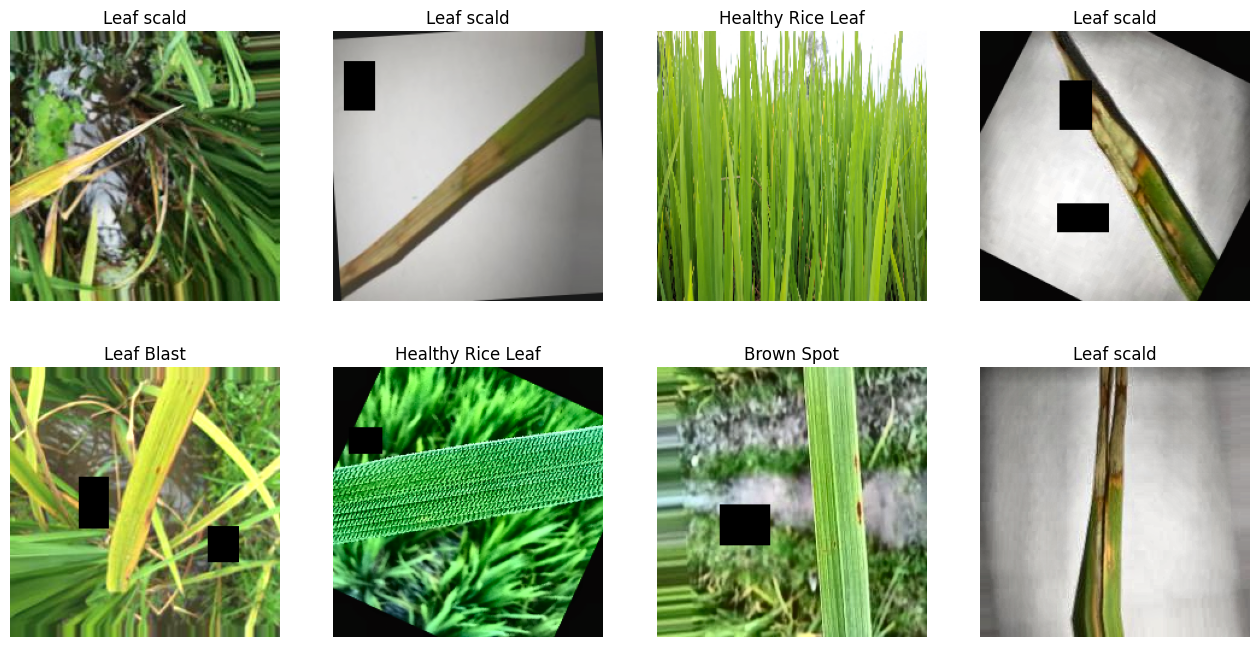

In [ ]:
# DATA PRE-PROCESSING AND AUGMENTATIONS

import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder

# --- CONFIGURATION ---
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 6
NUM_WORKERS = 2

# --- 1. ENCODE LABELS ---
encoder = LabelEncoder()
train_df['label_encoded'] = encoder.fit_transform(train_df['label'])
val_df['label_encoded'] = encoder.transform(val_df['label'])
test_df['label_encoded'] = encoder.transform(test_df['label'])
class_names = encoder.classes_
print(f"Class Mapping: {dict(zip(range(len(class_names)), class_names))}")

# --- 2. DEFINE AUGMENTATIONS (ALBUMENTATIONS) ---
def get_train_transforms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        
        # Geometric (Spatial)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        
        # Photometric (Color/Lighting)
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5), # Enhances disease spots
        
        # Regularization (Cutout / CoarseDropout)
        A.CoarseDropout(max_holes=8, max_height=20, max_width=20, fill_value=0, p=0.5),
        
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

# --- 3. CUSTOM DATASET CLASS ---
class RiceDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_path = row['filepath']
        label = row['label_encoded']
        
        # Read Image (OpenCV reads in BGR, convert to RGB)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply Augmentations
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
            
        return image, torch.tensor(label, dtype=torch.long)

# --- 4. CREATE DATALOADERS ---
train_dataset = RiceDataset(train_df, transforms=get_train_transforms())
val_dataset = RiceDataset(val_df, transforms=get_valid_transforms())
test_dataset = RiceDataset(test_df, transforms=get_valid_transforms())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("DataLoaders created successfully.")

# --- 5. VISUALIZATION CHECK ---
def show_batch(loader):
    images, labels = next(iter(loader))
    plt.figure(figsize=(16, 8))
    
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    for i in range(min(8, len(images))):
        ax = plt.subplot(2, 4, i + 1)
        img = images[i] * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

print("\nVisualizing Training Batch (with Augmentations):")
show_batch(train_loader)

In [ ]:
# TRAINING THE TEACHER: MOBILENETV2

import torch.nn as nn
import torch.optim as optim
from torchvision import models
import math

# --- CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. DEFINE MODEL ARCHITECTURE ---
class RiceMobileNet(nn.Module):
    def __init__(self, num_classes=6):
        super(RiceMobileNet, self).__init__()
        # Load Pretrained MobileNetV2
        self.model = models.mobilenet_v2(weights='DEFAULT')
        
        for param in self.model.features.parameters():
            param.requires_grad = False
            
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(1280, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Initialize Model
model = RiceMobileNet(num_classes=NUM_CLASSES)
model = model.to(device)

print("Model architecture created and moved to GPU.")

# --- 2. SOTA HYPERPARAMETERS ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-5)

print("\n--- Configuration Setup ---")
print(f"Loss: Label Smoothing CrossEntropy (0.1)")
print(f"Optimizer: AdamW (lr=1e-3)")
print(f"Scheduler: CosineAnnealingWarmRestarts")

Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 152MB/s]

Model architecture created and moved to GPU.

--- Configuration Setup ---
Loss: Label Smoothing CrossEntropy (0.1)
Optimizer: AdamW (lr=1e-3)
Scheduler: CosineAnnealingWarmRestarts


In [ ]:
import time
import copy
from tqdm import tqdm

# --- 0. REPRODUCIBILITY SETUP ---
def set_seed(seed=42):
    '''Sets the seed for reproducibility across all libraries.'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(42)

# --- 1. MIXUP HELPER FUNCTIONS ---
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- 2. TRAINING & VALIDATION FUNCTIONS ---
def train_one_epoch(model, loader, criterion, optimizer, scaler, use_mixup=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            if use_mixup and np.random.rand() < 0.5:
                images, targets_a, targets_b, lam = mixup_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
        
        # Backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader.dataset), correct / total

# --- 3. MAIN EXECUTION LOOP ---
scaler = torch.cuda.amp.GradScaler()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# === PHASE 1: WARMUP (Head Only) ===
print("--- PHASE 1: Warmup (Frozen Backbone) ---")
EPOCHS_WARMUP = 15

for epoch in range(EPOCHS_WARMUP):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, use_mixup=False)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS_WARMUP} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# === PHASE 2: FINE-TUNING ===
print("\n--- PHASE 2: Fine-Tuning (Unfrozen Backbone) ---")
print("Unfreezing all layers...")

for param in model.model.features.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

EPOCHS_FINE = 50
TOTAL_EPOCHS = EPOCHS_WARMUP + EPOCHS_FINE

for epoch in range(EPOCHS_WARMUP, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, use_mixup=True)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{TOTAL_EPOCHS} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')
        print("--> Best Model Saved!")

# Load best weights
model.load_state_dict(best_model_wts)
print(f"\nTraining Complete. Best Validation Accuracy: {best_acc:.4f}")

/tmp/ipykernel_55/881250879.py:95: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # Mixed Precision Scaler


Random seed set to 42
--- PHASE 1: Warmup (Frozen Backbone) ---


Training:   0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_55/881250879.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/15 - Train Loss: 0.5452 Acc: 0.9798 | Val Loss: 0.5978 Acc: 0.9217


Epoch 2/15 - Train Loss: 0.5774 Acc: 0.9605 | Val Loss: 0.5933 Acc: 0.9217


Epoch 3/15 - Train Loss: 0.5756 Acc: 0.9602 | Val Loss: 0.5859 Acc: 0.9217


Epoch 4/15 - Train Loss: 0.5663 Acc: 0.9631 | Val Loss: 0.5796 Acc: 0.9269


Epoch 5/15 - Train Loss: 0.5539 Acc: 0.9700 | Val Loss: 0.5872 Acc: 0.9295


Epoch 6/15 - Train Loss: 0.5695 Acc: 0.9644 | Val Loss: 0.5893 Acc: 0.9217


Epoch 7/15 - Train Loss: 0.5736 Acc: 0.9576 | Val Loss: 0.5751 Acc: 0.9295


Epoch 8/15 - Train Loss: 0.5674 Acc: 0.9641 | Val Loss: 0.5671 Acc: 0.9504


Epoch 9/15 - Train Loss: 0.5612 Acc: 0.9641 | Val Loss: 0.5597 Acc: 0.9504


Epoch 10/15 - Train Loss: 0.5461 Acc: 0.9716 | Val Loss: 0.5604 Acc: 0.9478


Epoch 11/15 - Train Loss: 0.5210 Acc: 0.9804 | Val Loss: 0.5461 Acc: 0.9530


Epoch 12/15 - Train Loss: 0.5158 Acc: 0.9850 | Val Loss: 0.5466 Acc: 0.9478


Epoch 13/15 - Train Loss: 0.5125 Acc: 0.9876 | Val Loss: 0.5440 Acc: 0.9556


Epoch 14/15 - Train Loss: 0.5104 Acc: 0.9905 | Val Loss: 0.5456 Acc: 0.9634


Epoch 15/15 - Train Loss: 0.5165 Acc: 0.9833 | Val Loss: 0.5430 Acc: 0.9530

--- PHASE 2: Fine-Tuning (Unfrozen Backbone) ---
Unfreezing all layers...


Epoch 16/65 - Train Loss: 0.8295 Acc: 0.7600 | Val Loss: 0.5646 Acc: 0.9373


Epoch 17/65 - Train Loss: 0.8282 Acc: 0.7620 | Val Loss: 0.5845 Acc: 0.9452


Epoch 18/65 - Train Loss: 0.7838 Acc: 0.8204 | Val Loss: 0.5684 Acc: 0.9478


Epoch 19/65 - Train Loss: 0.8296 Acc: 0.8100 | Val Loss: 0.5690 Acc: 0.9426


Epoch 20/65 - Train Loss: 0.7473 Acc: 0.8528 | Val Loss: 0.5602 Acc: 0.9426


Epoch 21/65 - Train Loss: 0.7977 Acc: 0.7391 | Val Loss: 0.5653 Acc: 0.9478


Epoch 22/65 - Train Loss: 0.8379 Acc: 0.7636 | Val Loss: 0.5651 Acc: 0.9426


Epoch 23/65 - Train Loss: 0.7838 Acc: 0.7878 | Val Loss: 0.5515 Acc: 0.9556


Epoch 24/65 - Train Loss: 0.7922 Acc: 0.8044 | Val Loss: 0.5430 Acc: 0.9556


Epoch 25/65 - Train Loss: 0.8631 Acc: 0.7437 | Val Loss: 0.5513 Acc: 0.9556


Epoch 26/65 - Train Loss: 0.7541 Acc: 0.8022 | Val Loss: 0.5658 Acc: 0.9478


Epoch 27/65 - Train Loss: 0.7110 Acc: 0.8155 | Val Loss: 0.5487 Acc: 0.9504


Epoch 28/65 - Train Loss: 0.7770 Acc: 0.7992 | Val Loss: 0.5570 Acc: 0.9530


Epoch 29/65 - Train Loss: 0.8247 Acc: 0.7796 | Val Loss: 0.5731 Acc: 0.9426


Epoch 30/65 - Train Loss: 0.7652 Acc: 0.7489 | Val Loss: 0.5443 Acc: 0.9530


Epoch 31/65 - Train Loss: 0.8280 Acc: 0.7581 | Val Loss: 0.5385 Acc: 0.9556


Epoch 32/65 - Train Loss: 0.8421 Acc: 0.7783 | Val Loss: 0.5477 Acc: 0.9634


Epoch 33/65 - Train Loss: 0.7628 Acc: 0.8498 | Val Loss: 0.5336 Acc: 0.9634


Epoch 34/65 - Train Loss: 0.8636 Acc: 0.7773 | Val Loss: 0.5343 Acc: 0.9608


Epoch 35/65 - Train Loss: 0.8201 Acc: 0.8093 | Val Loss: 0.5392 Acc: 0.9556


Epoch 36/65 - Train Loss: 0.7986 Acc: 0.8227 | Val Loss: 0.5410 Acc: 0.9661
--> Best Model Saved!


Epoch 37/65 - Train Loss: 0.8263 Acc: 0.7809 | Val Loss: 0.5268 Acc: 0.9634


Epoch 38/65 - Train Loss: 0.7569 Acc: 0.8002 | Val Loss: 0.5299 Acc: 0.9634


Epoch 39/65 - Train Loss: 0.8637 Acc: 0.7329 | Val Loss: 0.5271 Acc: 0.9634


Epoch 40/65 - Train Loss: 0.8081 Acc: 0.7963 | Val Loss: 0.5310 Acc: 0.9739
--> Best Model Saved!


Epoch 41/65 - Train Loss: 0.8252 Acc: 0.7444 | Val Loss: 0.5232 Acc: 0.9713


Epoch 42/65 - Train Loss: 0.7623 Acc: 0.7597 | Val Loss: 0.5244 Acc: 0.9661


Epoch 43/65 - Train Loss: 0.8004 Acc: 0.7832 | Val Loss: 0.5273 Acc: 0.9661


Epoch 44/65 - Train Loss: 0.8326 Acc: 0.7845 | Val Loss: 0.5267 Acc: 0.9713


Epoch 45/65 - Train Loss: 0.7749 Acc: 0.7773 | Val Loss: 0.5199 Acc: 0.9661


Epoch 46/65 - Train Loss: 0.8253 Acc: 0.7329 | Val Loss: 0.5336 Acc: 0.9608


Epoch 47/65 - Train Loss: 0.8491 Acc: 0.7316 | Val Loss: 0.5286 Acc: 0.9608


Epoch 48/65 - Train Loss: 0.8151 Acc: 0.7865 | Val Loss: 0.5257 Acc: 0.9713


Epoch 49/65 - Train Loss: 0.7859 Acc: 0.7460 | Val Loss: 0.5208 Acc: 0.9634


Epoch 50/65 - Train Loss: 0.7660 Acc: 0.8351 | Val Loss: 0.5258 Acc: 0.9739


Epoch 51/65 - Train Loss: 0.7422 Acc: 0.8230 | Val Loss: 0.5170 Acc: 0.9713


Epoch 52/65 - Train Loss: 0.7198 Acc: 0.8338 | Val Loss: 0.5103 Acc: 0.9713


Epoch 53/65 - Train Loss: 0.7883 Acc: 0.7542 | Val Loss: 0.5180 Acc: 0.9687


Epoch 54/65 - Train Loss: 0.7413 Acc: 0.7911 | Val Loss: 0.5142 Acc: 0.9687


Epoch 55/65 - Train Loss: 0.7815 Acc: 0.7649 | Val Loss: 0.5087 Acc: 0.9687


Epoch 56/65 - Train Loss: 0.7835 Acc: 0.7689 | Val Loss: 0.5134 Acc: 0.9713


Epoch 57/65 - Train Loss: 0.7580 Acc: 0.7568 | Val Loss: 0.5211 Acc: 0.9739


Epoch 58/65 - Train Loss: 0.7661 Acc: 0.7532 | Val Loss: 0.5165 Acc: 0.9713


Epoch 59/65 - Train Loss: 0.7939 Acc: 0.7604 | Val Loss: 0.5266 Acc: 0.9765
--> Best Model Saved!


Epoch 60/65 - Train Loss: 0.7631 Acc: 0.7473 | Val Loss: 0.5090 Acc: 0.9713


Epoch 61/65 - Train Loss: 0.7787 Acc: 0.7659 | Val Loss: 0.5210 Acc: 0.9739


Epoch 62/65 - Train Loss: 0.8023 Acc: 0.7333 | Val Loss: 0.5116 Acc: 0.9713


Epoch 63/65 - Train Loss: 0.7615 Acc: 0.8511 | Val Loss: 0.5069 Acc: 0.9713


Epoch 64/65 - Train Loss: 0.7814 Acc: 0.7525 | Val Loss: 0.5114 Acc: 0.9739


Epoch 65/65 - Train Loss: 0.7776 Acc: 0.7646 | Val Loss: 0.5262 Acc: 0.9739

Training Complete. Best Validation Accuracy: 0.9765


In [ ]:
# TRAINING THE TEACHER: RESNET18

import time
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# --- 0. REPRODUCIBILITY SETUP ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(42)

# --- CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 6
print(f"Using device: {device}")

# --- 1. DEFINE SOTA RESNET18 ARCHITECTURE ---
class RiceResNet(nn.Module):
    def __init__(self, num_classes=6):
        super(RiceResNet, self).__init__()
        # Load Pretrained ResNet18
        self.model = models.resnet18(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.fc.in_features

        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Initialize Model
model = RiceResNet(num_classes=NUM_CLASSES)
model = model.to(device)

# --- 2. OPTIMIZER & LOSS ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

print("ResNet18 Model Created. Ready for Training.")

# --- 3. MIXUP HELPER FUNCTIONS ---
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- 4. TRAINING & VALIDATION FUNCTIONS ---
def train_one_epoch(model, loader, criterion, optimizer, scaler, use_mixup=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            if use_mixup and np.random.rand() < 0.5: 
                images, targets_a, targets_b, lam = mixup_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return running_loss / len(loader.dataset), correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader.dataset), correct / total

# --- 5. EXECUTION LOOP ---
scaler = torch.cuda.amp.GradScaler()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# === PHASE 1: WARMUP (Head Only) ===
print("\n--- PHASE 1: Warmup (Frozen Backbone) ---")
EPOCHS_WARMUP = 15 

for epoch in range(EPOCHS_WARMUP):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, use_mixup=False)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS_WARMUP} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# === PHASE 2: FINE-TUNING ===
print("\n--- PHASE 2: Fine-Tuning (Unfrozen Backbone) ---")
print("Unfreezing all layers...")

for param in model.model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

EPOCHS_FINE = 50 
TOTAL_EPOCHS = EPOCHS_WARMUP + EPOCHS_FINE

for epoch in range(EPOCHS_WARMUP, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, use_mixup=True)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{TOTAL_EPOCHS} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model.pth')
        print("--> Best Model Saved!")

# Load best weights
model.load_state_dict(best_model_wts)
print(f"\nTraining Complete. Best Validation Accuracy: {best_acc:.4f}")

Random seed set to 42
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]
/tmp/ipykernel_55/3031869554.py:141: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


ResNet18 Model Created. Ready for Training.

--- PHASE 1: Warmup (Frozen Backbone) ---


Training:   0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_55/3031869554.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/15 - Train Loss: 1.5523 Acc: 0.4117 | Val Loss: 1.2344 Acc: 0.5822


Epoch 2/15 - Train Loss: 1.3966 Acc: 0.5096 | Val Loss: 1.1751 Acc: 0.6292


Epoch 3/15 - Train Loss: 1.3737 Acc: 0.5269 | Val Loss: 1.1464 Acc: 0.6554


Epoch 4/15 - Train Loss: 1.3418 Acc: 0.5393 | Val Loss: 1.1190 Acc: 0.6658


Epoch 5/15 - Train Loss: 1.3246 Acc: 0.5514 | Val Loss: 1.1138 Acc: 0.6658


Epoch 6/15 - Train Loss: 1.3011 Acc: 0.5599 | Val Loss: 1.1034 Acc: 0.6684


Epoch 7/15 - Train Loss: 1.3168 Acc: 0.5433 | Val Loss: 1.1038 Acc: 0.6841


Epoch 8/15 - Train Loss: 1.2915 Acc: 0.5730 | Val Loss: 1.1008 Acc: 0.6841


Epoch 9/15 - Train Loss: 1.3068 Acc: 0.5557 | Val Loss: 1.0970 Acc: 0.6736


Epoch 10/15 - Train Loss: 1.3180 Acc: 0.5472 | Val Loss: 1.1013 Acc: 0.6867


Epoch 11/15 - Train Loss: 1.3020 Acc: 0.5687 | Val Loss: 1.0981 Acc: 0.6841


Epoch 12/15 - Train Loss: 1.2953 Acc: 0.5687 | Val Loss: 1.0829 Acc: 0.6789


Epoch 13/15 - Train Loss: 1.3227 Acc: 0.5495 | Val Loss: 1.0928 Acc: 0.6606


Epoch 14/15 - Train Loss: 1.2916 Acc: 0.5570 | Val Loss: 1.0842 Acc: 0.6815


Epoch 15/15 - Train Loss: 1.2999 Acc: 0.5606 | Val Loss: 1.0761 Acc: 0.6841

--- PHASE 2: Fine-Tuning (Unfrozen Backbone) ---
Unfreezing all layers...


Epoch 16/65 - Train Loss: 1.2010 Acc: 0.5338 | Val Loss: 0.8637 Acc: 0.7833
--> Best Model Saved!


Epoch 17/65 - Train Loss: 1.0380 Acc: 0.6383 | Val Loss: 0.7705 Acc: 0.8538
--> Best Model Saved!


Epoch 18/65 - Train Loss: 0.9939 Acc: 0.6771 | Val Loss: 0.7351 Acc: 0.8590
--> Best Model Saved!


Epoch 19/65 - Train Loss: 0.9032 Acc: 0.7271 | Val Loss: 0.6806 Acc: 0.8851
--> Best Model Saved!


Epoch 20/65 - Train Loss: 0.8085 Acc: 0.7754 | Val Loss: 0.6445 Acc: 0.9008
--> Best Model Saved!


Epoch 21/65 - Train Loss: 0.9203 Acc: 0.6885 | Val Loss: 0.6206 Acc: 0.9373
--> Best Model Saved!


Epoch 22/65 - Train Loss: 0.7849 Acc: 0.7473 | Val Loss: 0.6072 Acc: 0.9269


Epoch 23/65 - Train Loss: 0.7962 Acc: 0.7675 | Val Loss: 0.5947 Acc: 0.9321


Epoch 24/65 - Train Loss: 0.7548 Acc: 0.7398 | Val Loss: 0.5849 Acc: 0.9321


Epoch 25/65 - Train Loss: 0.8331 Acc: 0.7222 | Val Loss: 0.5841 Acc: 0.9321


Epoch 26/65 - Train Loss: 0.7894 Acc: 0.7346 | Val Loss: 0.6155 Acc: 0.9138


Epoch 27/65 - Train Loss: 0.8041 Acc: 0.7444 | Val Loss: 0.5938 Acc: 0.9321


Epoch 28/65 - Train Loss: 0.7859 Acc: 0.7662 | Val Loss: 0.5693 Acc: 0.9426
--> Best Model Saved!


Epoch 29/65 - Train Loss: 0.8095 Acc: 0.7218 | Val Loss: 0.5610 Acc: 0.9452
--> Best Model Saved!


Epoch 30/65 - Train Loss: 0.8009 Acc: 0.6781 | Val Loss: 0.5610 Acc: 0.9504
--> Best Model Saved!


Epoch 31/65 - Train Loss: 0.7154 Acc: 0.7300 | Val Loss: 0.5411 Acc: 0.9556
--> Best Model Saved!


Epoch 32/65 - Train Loss: 0.7129 Acc: 0.7708 | Val Loss: 0.5347 Acc: 0.9634
--> Best Model Saved!


Epoch 33/65 - Train Loss: 0.7152 Acc: 0.8224 | Val Loss: 0.5271 Acc: 0.9608


Epoch 34/65 - Train Loss: 0.7531 Acc: 0.7646 | Val Loss: 0.5224 Acc: 0.9634


Epoch 35/65 - Train Loss: 0.6857 Acc: 0.7849 | Val Loss: 0.5229 Acc: 0.9582


Epoch 36/65 - Train Loss: 0.7398 Acc: 0.7551 | Val Loss: 0.5552 Acc: 0.9582


Epoch 37/65 - Train Loss: 0.7440 Acc: 0.7800 | Val Loss: 0.5489 Acc: 0.9426


Epoch 38/65 - Train Loss: 0.7188 Acc: 0.7979 | Val Loss: 0.5250 Acc: 0.9661
--> Best Model Saved!


Epoch 39/65 - Train Loss: 0.6762 Acc: 0.7777 | Val Loss: 0.5074 Acc: 0.9739
--> Best Model Saved!


Epoch 40/65 - Train Loss: 0.7881 Acc: 0.7382 | Val Loss: 0.5180 Acc: 0.9634


Epoch 41/65 - Train Loss: 0.7367 Acc: 0.7927 | Val Loss: 0.5133 Acc: 0.9687


Epoch 42/65 - Train Loss: 0.7079 Acc: 0.7613 | Val Loss: 0.5041 Acc: 0.9739


Epoch 43/65 - Train Loss: 0.6890 Acc: 0.7920 | Val Loss: 0.5089 Acc: 0.9661


Epoch 44/65 - Train Loss: 0.6376 Acc: 0.8165 | Val Loss: 0.5049 Acc: 0.9765
--> Best Model Saved!


Epoch 45/65 - Train Loss: 0.7042 Acc: 0.7398 | Val Loss: 0.5045 Acc: 0.9739


Epoch 46/65 - Train Loss: 0.6364 Acc: 0.8433 | Val Loss: 0.5292 Acc: 0.9530


Epoch 47/65 - Train Loss: 0.6831 Acc: 0.7666 | Val Loss: 0.5343 Acc: 0.9478


Epoch 48/65 - Train Loss: 0.7306 Acc: 0.6683 | Val Loss: 0.5253 Acc: 0.9582


Epoch 49/65 - Train Loss: 0.7114 Acc: 0.7708 | Val Loss: 0.5417 Acc: 0.9608


Epoch 50/65 - Train Loss: 0.6890 Acc: 0.7542 | Val Loss: 0.5150 Acc: 0.9634


Epoch 51/65 - Train Loss: 0.6930 Acc: 0.7427 | Val Loss: 0.5046 Acc: 0.9713


Epoch 52/65 - Train Loss: 0.6394 Acc: 0.8351 | Val Loss: 0.5137 Acc: 0.9661


Epoch 53/65 - Train Loss: 0.6723 Acc: 0.7679 | Val Loss: 0.5076 Acc: 0.9687


Epoch 54/65 - Train Loss: 0.6761 Acc: 0.7473 | Val Loss: 0.5051 Acc: 0.9687


Epoch 55/65 - Train Loss: 0.6821 Acc: 0.7711 | Val Loss: 0.5073 Acc: 0.9661


Epoch 56/65 - Train Loss: 0.6663 Acc: 0.7770 | Val Loss: 0.5430 Acc: 0.9608


Epoch 57/65 - Train Loss: 0.6998 Acc: 0.7300 | Val Loss: 0.5215 Acc: 0.9713


Epoch 58/65 - Train Loss: 0.6886 Acc: 0.8328 | Val Loss: 0.5275 Acc: 0.9582


Epoch 59/65 - Train Loss: 0.7603 Acc: 0.7633 | Val Loss: 0.5159 Acc: 0.9634


Epoch 60/65 - Train Loss: 0.6434 Acc: 0.7777 | Val Loss: 0.5046 Acc: 0.9687


Epoch 61/65 - Train Loss: 0.7289 Acc: 0.7424 | Val Loss: 0.5222 Acc: 0.9582


Epoch 62/65 - Train Loss: 0.6730 Acc: 0.7313 | Val Loss: 0.5039 Acc: 0.9634


Epoch 63/65 - Train Loss: 0.6214 Acc: 0.8270 | Val Loss: 0.5003 Acc: 0.9661


Epoch 65/65 - Train Loss: 0.6861 Acc: 0.7858 | Val Loss: 0.5012 Acc: 0.9661

Training Complete. Best Validation Accuracy: 0.9765


In [ ]:
# TRAINING THE TEACHER: DENSENET-121

import time
import copy
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# --- 0. REPRODUCIBILITY SETUP ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(42)

# --- CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 6
print(f"Using device: {device}")

# --- 1. DEFINE SOTA DENSENET121 ARCHITECTURE ---
class RiceDenseNet(nn.Module):
    def __init__(self, num_classes=6):
        super(RiceDenseNet, self).__init__()
        # Load Pretrained DenseNet121
        self.model = models.densenet121(weights='DEFAULT')
        for param in self.model.features.parameters():
            param.requires_grad = False

        num_ftrs = self.model.classifier.in_features 
        
        # Custom SOTA Head
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Initialize Model
model = RiceDenseNet(num_classes=NUM_CLASSES)
model = model.to(device)

# --- 2. OPTIMIZER & LOSS ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.model.classifier.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

print("DenseNet121 Model Created. Ready for Training.")

# --- 3. MIXUP HELPER FUNCTIONS ---
def mixup_data(x, y, alpha=0.4): 
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- 4. TRAINING & VALIDATION FUNCTIONS ---
def train_one_epoch(model, loader, criterion, optimizer, scaler, use_mixup=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            if use_mixup and np.random.rand() < 0.5: 
                images, targets_a, targets_b, lam = mixup_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return running_loss / len(loader.dataset), correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader.dataset), correct / total

# --- 5. EXECUTION LOOP ---
scaler = torch.cuda.amp.GradScaler()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# === PHASE 1: WARMUP ===
print("\n--- PHASE 1: Warmup (Frozen Backbone) ---")
EPOCHS_WARMUP = 15

for epoch in range(EPOCHS_WARMUP):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, use_mixup=False)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS_WARMUP} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# === PHASE 2: FINE-TUNING===
print("\n--- PHASE 2: Fine-Tuning (Unfrozen Backbone) ---")
print("Unfreezing all layers...")

for param in model.model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

EPOCHS_FINE = 50
TOTAL_EPOCHS = EPOCHS_WARMUP + EPOCHS_FINE

for epoch in range(EPOCHS_WARMUP, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, use_mixup=True)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{TOTAL_EPOCHS} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model_densenet.pth')
        print("--> Best Model Saved!")

# Load best weights
model.load_state_dict(best_model_wts)
print(f"\nTraining Complete. Best Validation Accuracy: {best_acc:.4f}")

Random seed set to 42
Using device: cuda
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 176MB/s]
/tmp/ipykernel_55/1853339630.py:140: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


DenseNet121 Model Created. Ready for Training.

--- PHASE 1: Warmup (Frozen Backbone) ---


Training:   0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_55/1853339630.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/15 - Train Loss: 1.4799 Acc: 0.4665 | Val Loss: 1.0805 Acc: 0.6997


Epoch 2/15 - Train Loss: 1.3259 Acc: 0.5452 | Val Loss: 1.0142 Acc: 0.7389


Epoch 3/15 - Train Loss: 1.2879 Acc: 0.5775 | Val Loss: 1.0053 Acc: 0.7389


Epoch 4/15 - Train Loss: 1.2627 Acc: 0.5906 | Val Loss: 0.9787 Acc: 0.7389


Epoch 5/15 - Train Loss: 1.2366 Acc: 0.5945 | Val Loss: 0.9856 Acc: 0.7154


Epoch 6/15 - Train Loss: 1.2287 Acc: 0.6050 | Val Loss: 0.9835 Acc: 0.7389


Epoch 7/15 - Train Loss: 1.1949 Acc: 0.6180 | Val Loss: 0.9594 Acc: 0.7546


Epoch 8/15 - Train Loss: 1.2025 Acc: 0.6115 | Val Loss: 0.9515 Acc: 0.7755


Epoch 9/15 - Train Loss: 1.1981 Acc: 0.6246 | Val Loss: 0.9509 Acc: 0.7728


Epoch 10/15 - Train Loss: 1.2021 Acc: 0.6164 | Val Loss: 0.9494 Acc: 0.7676


Epoch 11/15 - Train Loss: 1.1848 Acc: 0.6239 | Val Loss: 0.9458 Acc: 0.7728


Epoch 12/15 - Train Loss: 1.1937 Acc: 0.6281 | Val Loss: 0.9438 Acc: 0.7781


Epoch 13/15 - Train Loss: 1.2157 Acc: 0.6138 | Val Loss: 0.9464 Acc: 0.7676


Epoch 14/15 - Train Loss: 1.1813 Acc: 0.6190 | Val Loss: 0.9332 Acc: 0.7572


Epoch 15/15 - Train Loss: 1.1743 Acc: 0.6340 | Val Loss: 0.9258 Acc: 0.7676

--- PHASE 2: Fine-Tuning (Unfrozen Backbone) ---
Unfreezing all layers...


Epoch 16/65 - Train Loss: 1.1171 Acc: 0.5837 | Val Loss: 0.7627 Acc: 0.8355
--> Best Model Saved!


Epoch 17/65 - Train Loss: 1.0217 Acc: 0.6565 | Val Loss: 0.7089 Acc: 0.8747
--> Best Model Saved!


Epoch 18/65 - Train Loss: 0.9728 Acc: 0.6902 | Val Loss: 0.6807 Acc: 0.8903
--> Best Model Saved!


Epoch 19/65 - Train Loss: 0.8705 Acc: 0.7509 | Val Loss: 0.6040 Acc: 0.9269
--> Best Model Saved!


Epoch 20/65 - Train Loss: 0.7766 Acc: 0.7966 | Val Loss: 0.5848 Acc: 0.9426
--> Best Model Saved!


Epoch 21/65 - Train Loss: 0.8897 Acc: 0.6957 | Val Loss: 0.5809 Acc: 0.9399


Epoch 22/65 - Train Loss: 0.7523 Acc: 0.7613 | Val Loss: 0.5600 Acc: 0.9608
--> Best Model Saved!


Epoch 23/65 - Train Loss: 0.7626 Acc: 0.7845 | Val Loss: 0.5464 Acc: 0.9713
--> Best Model Saved!


Epoch 24/65 - Train Loss: 0.7345 Acc: 0.7444 | Val Loss: 0.5443 Acc: 0.9713


Epoch 25/65 - Train Loss: 0.8179 Acc: 0.7388 | Val Loss: 0.5457 Acc: 0.9687


Epoch 26/65 - Train Loss: 0.7658 Acc: 0.7411 | Val Loss: 0.5539 Acc: 0.9556


Epoch 27/65 - Train Loss: 0.7816 Acc: 0.7564 | Val Loss: 0.5346 Acc: 0.9687


Epoch 28/65 - Train Loss: 0.7483 Acc: 0.7845 | Val Loss: 0.5534 Acc: 0.9582


Epoch 29/65 - Train Loss: 0.7792 Acc: 0.7372 | Val Loss: 0.5346 Acc: 0.9765
--> Best Model Saved!


Epoch 30/65 - Train Loss: 0.7826 Acc: 0.6905 | Val Loss: 0.5346 Acc: 0.9661


Epoch 31/65 - Train Loss: 0.6921 Acc: 0.7405 | Val Loss: 0.4992 Acc: 0.9817
--> Best Model Saved!


Epoch 32/65 - Train Loss: 0.6998 Acc: 0.7839 | Val Loss: 0.4985 Acc: 0.9791


Epoch 33/65 - Train Loss: 0.7076 Acc: 0.8211 | Val Loss: 0.4940 Acc: 0.9739


Epoch 34/65 - Train Loss: 0.7301 Acc: 0.7682 | Val Loss: 0.4947 Acc: 0.9791


Epoch 35/65 - Train Loss: 0.6746 Acc: 0.7790 | Val Loss: 0.4956 Acc: 0.9765


Epoch 36/65 - Train Loss: 0.7174 Acc: 0.7610 | Val Loss: 0.5262 Acc: 0.9608


Epoch 37/65 - Train Loss: 0.7249 Acc: 0.7862 | Val Loss: 0.5150 Acc: 0.9661


Epoch 38/65 - Train Loss: 0.6933 Acc: 0.8103 | Val Loss: 0.5173 Acc: 0.9634


Epoch 39/65 - Train Loss: 0.6530 Acc: 0.7839 | Val Loss: 0.4944 Acc: 0.9739


Epoch 40/65 - Train Loss: 0.7741 Acc: 0.7391 | Val Loss: 0.5043 Acc: 0.9739


Epoch 41/65 - Train Loss: 0.7157 Acc: 0.8044 | Val Loss: 0.4955 Acc: 0.9791


Epoch 42/65 - Train Loss: 0.6984 Acc: 0.7672 | Val Loss: 0.4869 Acc: 0.9791


Epoch 43/65 - Train Loss: 0.6818 Acc: 0.7963 | Val Loss: 0.4834 Acc: 0.9765


Epoch 44/65 - Train Loss: 0.6301 Acc: 0.8266 | Val Loss: 0.4823 Acc: 0.9817


Epoch 45/65 - Train Loss: 0.7015 Acc: 0.7489 | Val Loss: 0.4814 Acc: 0.9791


Epoch 46/65 - Train Loss: 0.6300 Acc: 0.8394 | Val Loss: 0.4852 Acc: 0.9791


Epoch 47/65 - Train Loss: 0.6820 Acc: 0.7770 | Val Loss: 0.5089 Acc: 0.9661


Epoch 48/65 - Train Loss: 0.7145 Acc: 0.6683 | Val Loss: 0.5027 Acc: 0.9713


Epoch 49/65 - Train Loss: 0.6984 Acc: 0.7741 | Val Loss: 0.4961 Acc: 0.9817


Epoch 50/65 - Train Loss: 0.6738 Acc: 0.7545 | Val Loss: 0.4806 Acc: 0.9739


Epoch 51/65 - Train Loss: 0.6769 Acc: 0.7476 | Val Loss: 0.4844 Acc: 0.9739


Epoch 52/65 - Train Loss: 0.6284 Acc: 0.8404 | Val Loss: 0.4824 Acc: 0.9791


Epoch 53/65 - Train Loss: 0.6615 Acc: 0.7731 | Val Loss: 0.4816 Acc: 0.9817


Epoch 54/65 - Train Loss: 0.6827 Acc: 0.7385 | Val Loss: 0.4821 Acc: 0.9765


Epoch 55/65 - Train Loss: 0.6703 Acc: 0.7669 | Val Loss: 0.4808 Acc: 0.9817


Epoch 56/65 - Train Loss: 0.6646 Acc: 0.7770 | Val Loss: 0.5093 Acc: 0.9661


Epoch 57/65 - Train Loss: 0.6944 Acc: 0.7329 | Val Loss: 0.4947 Acc: 0.9739


Epoch 58/65 - Train Loss: 0.6799 Acc: 0.8276 | Val Loss: 0.4872 Acc: 0.9791


Epoch 59/65 - Train Loss: 0.7570 Acc: 0.7653 | Val Loss: 0.4933 Acc: 0.9791


Epoch 60/65 - Train Loss: 0.6380 Acc: 0.7751 | Val Loss: 0.4884 Acc: 0.9713


Epoch 61/65 - Train Loss: 0.7096 Acc: 0.7584 | Val Loss: 0.4817 Acc: 0.9765


Epoch 62/65 - Train Loss: 0.6685 Acc: 0.7395 | Val Loss: 0.4798 Acc: 0.9739


Epoch 63/65 - Train Loss: 0.6192 Acc: 0.8175 | Val Loss: 0.4804 Acc: 0.9765


Epoch 64/65 - Train Loss: 0.6684 Acc: 0.8051 | Val Loss: 0.4803 Acc: 0.9765


Epoch 65/65 - Train Loss: 0.6861 Acc: 0.7800 | Val Loss: 0.4786 Acc: 0.9791

Training Complete. Best Validation Accuracy: 0.9817


In [ ]:
# TRAINING THE STUDENT: MOBILENET V3 SMALL (0.5x WIDTH)
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import timm
    print("timm library is already installed.")
except ImportError:
    print("Installing timm library...")
    install('timm')
    import timm

import time
import copy
import random
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# --- 0. REPRODUCIBILITY SETUP ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(42)

# --- CONFIGURATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 6
print(f"Using device: {device}")

# --- 1. DEFINE SOTA MOBILENET V3 SMALL (0.5x WIDTH) ---
class RiceMobileNetV3Small_050(nn.Module):
    def __init__(self, num_classes=6):
        super(RiceMobileNetV3Small_050, self).__init__()
        
        # Load Pretrained MobileNetV3 Small 0.5x from TIMM
        print("Loading mobilenetv3_small_050 (0.5x Width)...")
        self.model = timm.create_model('mobilenetv3_small_050', pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.Hardswish(), 
            nn.Dropout(p=0.1),
            nn.Linear(512, 128),
            nn.Hardswish(),
            nn.Dropout(p=0.1),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

# Initialize Model
model = RiceMobileNetV3Small_050(num_classes=NUM_CLASSES)
model = model.to(device)

# --- 2. OPTIMIZER & LOSS ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.model.classifier.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

print("MobileNetV3 Small (0.5x) Created. Ready for Training.")

# --- 3. MIXUP HELPER FUNCTIONS ---
def mixup_data(x, y, alpha=0.1):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- 4. TRAINING & VALIDATION FUNCTIONS ---
def train_one_epoch(model, loader, criterion, optimizer, scaler, use_mixup=False):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            if use_mixup and np.random.rand() < 0.5: 
                images, targets_a, targets_b, lam = mixup_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return running_loss / len(loader.dataset), correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader.dataset), correct / total

# --- 5. EXECUTION LOOP ---
scaler = torch.cuda.amp.GradScaler()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# === PHASE 1: WARMUP ===
print("\n--- PHASE 1: Warmup (Frozen Backbone) ---")
EPOCHS_WARMUP = 15 

for epoch in range(EPOCHS_WARMUP):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, use_mixup=False)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS_WARMUP} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# === PHASE 2: FINE-TUNING ===
print("\n--- PHASE 2: Fine-Tuning (Unfrozen Backbone) ---")
print("Unfreezing all layers...")

for param in model.model.parameters():
    param.requires_grad = True
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)

EPOCHS_FINE = 75
TOTAL_EPOCHS = EPOCHS_WARMUP + EPOCHS_FINE

for epoch in range(EPOCHS_WARMUP, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, use_mixup=True)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{TOTAL_EPOCHS} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_model_mobilenet_050.pth')
        print("--> Best Model Saved!")

# Load best weights
model.load_state_dict(best_model_wts)
print(f"\nTraining Complete. Best Validation Accuracy: {best_acc:.4f}")

# --- 6. CALCULATE & PRINT MODEL SIZE ---
def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

model_size = get_model_size_mb(model)
print(f"\n===========================================")
print(f"FINAL MODEL SIZE (0.5x Width): {model_size:.2f} MB")
print(f"===========================================")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

timm library is already installed.
Random seed set to 42
Using device: cuda
Loading mobilenetv3_small_050 (0.5x Width)...


model.safetensors:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

/tmp/ipykernel_55/681401976.py:159: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


MobileNetV3 Small (0.5x) Created. Ready for Training.

--- PHASE 1: Warmup (Frozen Backbone) ---


Training:   0%|          | 0/96 [00:00<?, ?it/s]/tmp/ipykernel_55/681401976.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/15 - Train Loss: 1.3985 Acc: 0.5057 | Val Loss: 1.1363 Acc: 0.6658


Epoch 2/15 - Train Loss: 1.1277 Acc: 0.6709 | Val Loss: 1.0112 Acc: 0.7258


Epoch 3/15 - Train Loss: 1.0294 Acc: 0.7215 | Val Loss: 0.9677 Acc: 0.7285


Epoch 4/15 - Train Loss: 1.0133 Acc: 0.7209 | Val Loss: 0.9387 Acc: 0.7598


Epoch 5/15 - Train Loss: 0.9672 Acc: 0.7483 | Val Loss: 0.9096 Acc: 0.7676


Epoch 6/15 - Train Loss: 0.9436 Acc: 0.7551 | Val Loss: 0.8950 Acc: 0.7728


Epoch 7/15 - Train Loss: 0.9136 Acc: 0.7695 | Val Loss: 0.8941 Acc: 0.7859


Epoch 8/15 - Train Loss: 0.8864 Acc: 0.7897 | Val Loss: 0.8914 Acc: 0.7833


Epoch 9/15 - Train Loss: 0.8679 Acc: 0.8057 | Val Loss: 0.8600 Acc: 0.7885


Epoch 10/15 - Train Loss: 0.8740 Acc: 0.7979 | Val Loss: 0.8618 Acc: 0.7990


Epoch 11/15 - Train Loss: 0.9377 Acc: 0.7672 | Val Loss: 0.8740 Acc: 0.8016


Epoch 12/15 - Train Loss: 0.9170 Acc: 0.7731 | Val Loss: 0.8876 Acc: 0.7963


Epoch 13/15 - Train Loss: 0.9101 Acc: 0.7790 | Val Loss: 0.8661 Acc: 0.7990


Epoch 14/15 - Train Loss: 0.8824 Acc: 0.7973 | Val Loss: 0.8910 Acc: 0.7937


Epoch 15/15 - Train Loss: 0.8841 Acc: 0.7907 | Val Loss: 0.9072 Acc: 0.7990

--- PHASE 2: Fine-Tuning (Unfrozen Backbone) ---
Unfreezing all layers...


Epoch 16/90 - Train Loss: 0.8833 Acc: 0.6774 | Val Loss: 0.8132 Acc: 0.8355
--> Best Model Saved!


Epoch 17/90 - Train Loss: 0.8304 Acc: 0.6882 | Val Loss: 0.7919 Acc: 0.8407
--> Best Model Saved!


Epoch 18/90 - Train Loss: 0.8627 Acc: 0.7267 | Val Loss: 0.7840 Acc: 0.8381


Epoch 19/90 - Train Loss: 0.8110 Acc: 0.6419 | Val Loss: 0.7775 Acc: 0.8486
--> Best Model Saved!


Epoch 20/90 - Train Loss: 0.7825 Acc: 0.7267 | Val Loss: 0.7469 Acc: 0.8590
--> Best Model Saved!


Epoch 21/90 - Train Loss: 0.8040 Acc: 0.7042 | Val Loss: 0.7542 Acc: 0.8433


Epoch 22/90 - Train Loss: 0.7743 Acc: 0.7271 | Val Loss: 0.7443 Acc: 0.8642
--> Best Model Saved!


Epoch 23/90 - Train Loss: 0.7862 Acc: 0.6912 | Val Loss: 0.7342 Acc: 0.8668
--> Best Model Saved!


Epoch 24/90 - Train Loss: 0.7922 Acc: 0.6513 | Val Loss: 0.7325 Acc: 0.8695
--> Best Model Saved!


Epoch 25/90 - Train Loss: 0.7774 Acc: 0.7094 | Val Loss: 0.7404 Acc: 0.8747
--> Best Model Saved!


Epoch 26/90 - Train Loss: 0.8049 Acc: 0.6732 | Val Loss: 0.7424 Acc: 0.8799
--> Best Model Saved!


Epoch 27/90 - Train Loss: 0.7425 Acc: 0.7160 | Val Loss: 0.7382 Acc: 0.8668


Epoch 28/90 - Train Loss: 0.7948 Acc: 0.6869 | Val Loss: 0.7233 Acc: 0.8747


Epoch 29/90 - Train Loss: 0.7639 Acc: 0.7068 | Val Loss: 0.7070 Acc: 0.8903
--> Best Model Saved!


Epoch 30/90 - Train Loss: 0.7865 Acc: 0.7003 | Val Loss: 0.7123 Acc: 0.8851


Epoch 31/90 - Train Loss: 0.7942 Acc: 0.6536 | Val Loss: 0.6920 Acc: 0.8851


Epoch 32/90 - Train Loss: 0.7374 Acc: 0.6970 | Val Loss: 0.6856 Acc: 0.8982
--> Best Model Saved!


Epoch 33/90 - Train Loss: 0.7038 Acc: 0.7757 | Val Loss: 0.6843 Acc: 0.8930


Epoch 34/90 - Train Loss: 0.6969 Acc: 0.7124 | Val Loss: 0.6859 Acc: 0.9008
--> Best Model Saved!


Epoch 35/90 - Train Loss: 0.7345 Acc: 0.7617 | Val Loss: 0.6923 Acc: 0.8982


Epoch 36/90 - Train Loss: 0.7369 Acc: 0.7388 | Val Loss: 0.6799 Acc: 0.8982


Epoch 37/90 - Train Loss: 0.7015 Acc: 0.6892 | Val Loss: 0.6757 Acc: 0.8956


Epoch 38/90 - Train Loss: 0.7427 Acc: 0.7140 | Val Loss: 0.6723 Acc: 0.8982


Epoch 39/90 - Train Loss: 0.7306 Acc: 0.7183 | Val Loss: 0.6679 Acc: 0.8930


Epoch 40/90 - Train Loss: 0.7165 Acc: 0.7241 | Val Loss: 0.6592 Acc: 0.8982


Epoch 41/90 - Train Loss: 0.6688 Acc: 0.7342 | Val Loss: 0.6527 Acc: 0.9034
--> Best Model Saved!


Epoch 42/90 - Train Loss: 0.7119 Acc: 0.7032 | Val Loss: 0.6522 Acc: 0.9060
--> Best Model Saved!


Epoch 43/90 - Train Loss: 0.7057 Acc: 0.7294 | Val Loss: 0.6508 Acc: 0.9034


Epoch 44/90 - Train Loss: 0.6948 Acc: 0.7633 | Val Loss: 0.6466 Acc: 0.9112
--> Best Model Saved!


Epoch 45/90 - Train Loss: 0.6808 Acc: 0.7591 | Val Loss: 0.6533 Acc: 0.8982


Epoch 46/90 - Train Loss: 0.7024 Acc: 0.7911 | Val Loss: 0.6467 Acc: 0.9138
--> Best Model Saved!


Epoch 47/90 - Train Loss: 0.7168 Acc: 0.7225 | Val Loss: 0.6577 Acc: 0.9138


Epoch 48/90 - Train Loss: 0.6982 Acc: 0.7483 | Val Loss: 0.6414 Acc: 0.9164
--> Best Model Saved!


Epoch 49/90 - Train Loss: 0.6701 Acc: 0.7721 | Val Loss: 0.6412 Acc: 0.9112


Epoch 50/90 - Train Loss: 0.6684 Acc: 0.7411 | Val Loss: 0.6276 Acc: 0.9269
--> Best Model Saved!


Epoch 51/90 - Train Loss: 0.6738 Acc: 0.6823 | Val Loss: 0.6364 Acc: 0.9060


Epoch 52/90 - Train Loss: 0.6883 Acc: 0.7444 | Val Loss: 0.6301 Acc: 0.9138


Epoch 53/90 - Train Loss: 0.6867 Acc: 0.7418 | Val Loss: 0.6181 Acc: 0.9243


Epoch 54/90 - Train Loss: 0.6479 Acc: 0.7395 | Val Loss: 0.6221 Acc: 0.9269


Epoch 55/90 - Train Loss: 0.6302 Acc: 0.7989 | Val Loss: 0.6239 Acc: 0.9243


Epoch 56/90 - Train Loss: 0.6814 Acc: 0.7349 | Val Loss: 0.6279 Acc: 0.9034


Epoch 57/90 - Train Loss: 0.6762 Acc: 0.6836 | Val Loss: 0.6260 Acc: 0.9217


Epoch 58/90 - Train Loss: 0.6688 Acc: 0.7617 | Val Loss: 0.6206 Acc: 0.9243


Epoch 59/90 - Train Loss: 0.6459 Acc: 0.7346 | Val Loss: 0.6212 Acc: 0.9164


Epoch 60/90 - Train Loss: 0.6660 Acc: 0.7052 | Val Loss: 0.6148 Acc: 0.9217


Epoch 61/90 - Train Loss: 0.6561 Acc: 0.7897 | Val Loss: 0.6082 Acc: 0.9217


Epoch 62/90 - Train Loss: 0.6748 Acc: 0.7855 | Val Loss: 0.6111 Acc: 0.9269


Epoch 63/90 - Train Loss: 0.6343 Acc: 0.7385 | Val Loss: 0.6042 Acc: 0.9191


Epoch 64/90 - Train Loss: 0.6366 Acc: 0.7169 | Val Loss: 0.6014 Acc: 0.9243


Epoch 65/90 - Train Loss: 0.6472 Acc: 0.7235 | Val Loss: 0.5989 Acc: 0.9217


Epoch 66/90 - Train Loss: 0.6447 Acc: 0.7600 | Val Loss: 0.6025 Acc: 0.9191


Epoch 67/90 - Train Loss: 0.6077 Acc: 0.7862 | Val Loss: 0.5956 Acc: 0.9269


Epoch 68/90 - Train Loss: 0.6628 Acc: 0.7607 | Val Loss: 0.5866 Acc: 0.9399
--> Best Model Saved!


Epoch 69/90 - Train Loss: 0.6699 Acc: 0.7202 | Val Loss: 0.5882 Acc: 0.9217


Epoch 70/90 - Train Loss: 0.6476 Acc: 0.7911 | Val Loss: 0.5835 Acc: 0.9399


Epoch 71/90 - Train Loss: 0.6184 Acc: 0.7803 | Val Loss: 0.5835 Acc: 0.9426
--> Best Model Saved!


Epoch 72/90 - Train Loss: 0.6743 Acc: 0.7822 | Val Loss: 0.5788 Acc: 0.9426


Epoch 73/90 - Train Loss: 0.5996 Acc: 0.7594 | Val Loss: 0.5801 Acc: 0.9321


Epoch 74/90 - Train Loss: 0.6154 Acc: 0.7937 | Val Loss: 0.5818 Acc: 0.9399


Epoch 75/90 - Train Loss: 0.6002 Acc: 0.7437 | Val Loss: 0.5820 Acc: 0.9373


Epoch 76/90 - Train Loss: 0.6294 Acc: 0.7372 | Val Loss: 0.5807 Acc: 0.9347


Epoch 77/90 - Train Loss: 0.6026 Acc: 0.8175 | Val Loss: 0.5760 Acc: 0.9478
--> Best Model Saved!


Epoch 78/90 - Train Loss: 0.6070 Acc: 0.7516 | Val Loss: 0.5677 Acc: 0.9452


Epoch 79/90 - Train Loss: 0.5974 Acc: 0.7933 | Val Loss: 0.5683 Acc: 0.9452


Epoch 80/90 - Train Loss: 0.6160 Acc: 0.7835 | Val Loss: 0.5667 Acc: 0.9478


Epoch 81/90 - Train Loss: 0.5919 Acc: 0.7630 | Val Loss: 0.5635 Acc: 0.9452


Epoch 82/90 - Train Loss: 0.5989 Acc: 0.7698 | Val Loss: 0.5620 Acc: 0.9452


Epoch 83/90 - Train Loss: 0.5959 Acc: 0.7532 | Val Loss: 0.5617 Acc: 0.9504
--> Best Model Saved!


Epoch 84/90 - Train Loss: 0.6062 Acc: 0.7822 | Val Loss: 0.5588 Acc: 0.9478


Epoch 85/90 - Train Loss: 0.5882 Acc: 0.7434 | Val Loss: 0.5621 Acc: 0.9504


Epoch 86/90 - Train Loss: 0.6105 Acc: 0.8035 | Val Loss: 0.5581 Acc: 0.9504


Epoch 87/90 - Train Loss: 0.5927 Acc: 0.7728 | Val Loss: 0.5531 Acc: 0.9504


Epoch 88/90 - Train Loss: 0.6359 Acc: 0.7493 | Val Loss: 0.5539 Acc: 0.9504


Epoch 89/90 - Train Loss: 0.5954 Acc: 0.8152 | Val Loss: 0.5484 Acc: 0.9582
--> Best Model Saved!


Epoch 90/90 - Train Loss: 0.5970 Acc: 0.7212 | Val Loss: 0.5465 Acc: 0.9530

Training Complete. Best Validation Accuracy: 0.9582

FINAL MODEL SIZE (0.5x Width): 4.45 MB


In [16]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"===========================================")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Frozen Parameters:    {total_params - trainable_params:,}")
    print(f"===========================================")

# Run the function on your loaded model
count_parameters(model)

Total Parameters:     1,159,462
Trainable Parameters: 1,159,462
Frozen Parameters:    0
